# Libraries

Import your libraries
https://towardsdatascience.com/how-to-use-convolutional-neural-networks-for-time-series-classification-56b1b0a07a57

In [1]:
import torch
import os
import math
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from torch.utils.data import DataLoader, TensorDataset
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from torch import nn, optim
import torch.nn.functional as F

using gpu 3


# Importing Data

Import the CSV file with Actions, Sum and Div as a Dataframe called df. Fill the empty values of Action with 0. 
Replace NaN values with 0. Delete first 100 rows. 

In [2]:
#load in df
Player = 15
Game = 2
Quarter = 2

df = pd.read_csv('matrix_Player_15_game_2_QuarterSplit_V2.csv') #Raw data with overlap

chunks = [df[i:i+100] for i in range(0,df.shape[0],50)]

df = pd.concat(chunks)

df['wheelRotationalSpeedX_Diff'] = np.insert(np.diff(df.wheelRotationalSpeedX,n=1),0,0)

#Clean and expand dataset
df = df.drop(columns = ['Unnamed: 0'])

# Data Preparating

Split data into a train and val set 

In [3]:
train = df[df.Quarter != Quarter]
val = df[df.Quarter == Quarter]

def rounddown(x):
    return (int(math.ceil(x / 100.0)) * 100) - 100

features = ['wheelRotationalSpeedX','frameRotationalSpeedZ','frAcc','wheelRotationalSpeedX_Diff']

X_train = train[features]
X_train = X_train.iloc[0:rounddown(len(X_train))]

y_train = train[['Action']]
y_train = y_train.iloc[0:rounddown(len(y_train))]

X_val = val[features]
X_val = X_val.iloc[0:rounddown(len(X_val))]

y_val = val[['Action']]
y_val = y_val.iloc[0:rounddown(len(y_val))]

In [4]:
y_train = np.array_split(y_train, int(len(y_train)/100))
y_train = np.asarray(y_train)

y = []
for i in range (0,len(y_train)):
    y.append(y_train[i].max())
y_train = np.asarray(y)
y_train = pd.DataFrame(y_train)


y_val = np.array_split(y_val, int(len(y_val)/100))
y_val = np.asarray(y_val)

y = []
for i in range (0,len(y_val)):
    y.append(y_val[i].max())
y_val = np.asarray(y)
y_val= pd.DataFrame(y_val)

## Slicing the train and test sets into windows of 1 sec (100 samples per window)

In [5]:
size_batch = 100
channels = 3

In [6]:
A1 = X_train['wheelRotationalSpeedX'].to_numpy().reshape(int(len(X_train)/size_batch),size_batch)
A2 = X_train['frameRotationalSpeedZ'].to_numpy().reshape(int(len(X_train)/size_batch),size_batch)
A3 = X_train['frAcc'].to_numpy().reshape(int(len(X_train)/size_batch),size_batch)

X_train = np.stack((A1,A2,A3),axis=1)
X_train = X_train.reshape([int(len(X_train)),channels,size_batch])
print(X_train.shape)

(6904, 3, 100)


In [7]:
A1 = X_val['wheelRotationalSpeedX'].to_numpy().reshape(int(len(X_val)/size_batch),size_batch)
A2 = X_val['frameRotationalSpeedZ'].to_numpy().reshape(int(len(X_val)/size_batch),size_batch)
A3 = X_val['frAcc'].to_numpy().reshape(int(len(X_val)/size_batch),size_batch)

X_val = np.stack((A1,A2,A3),axis=1)
X_val = X_val.reshape([int(len(X_val)),channels,size_batch])

## Balancing the data (Copy all positives and paste them after X_train)

In [8]:
X_train_Resample = pd.DataFrame()
y_train_Resample = pd.DataFrame()

y_train = y_train.squeeze()
y_train = y_train.to_numpy()

for i in range(0,len(y_train)):
    if y_train[i] == 1:
        X_train_Resample = X_train_Resample.append(pd.DataFrame(X_train[i]))    
        y_train_Resample = y_train_Resample.append(pd.DataFrame([1]))

/opt/jupyterhub/anaconda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

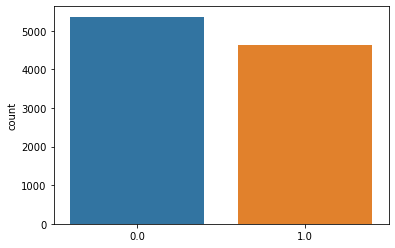

In [9]:
X_train_Resample = X_train_Resample.to_numpy()
X_train_Resample = X_train_Resample.reshape([int(len(X_train_Resample)/channels),channels,size_batch])

y_train_Resample = y_train_Resample.to_numpy().reshape([len(y_train_Resample)])

for i in range(0,1):
    X_train_Resample = np.concatenate((X_train_Resample, X_train_Resample), axis=0)
    y_train_Resample = np.concatenate((y_train_Resample, y_train_Resample), axis=0)
    
X_train_Resample = np.concatenate((X_train, X_train_Resample), axis=0)
y_train_Resample = np.concatenate((y_train, y_train_Resample), axis=0)

sns.countplot(y_train_Resample)

## Convert the X_train, X_test, y_train, y_test to Tensors

In [10]:
X_train = torch.from_numpy(X_train_Resample).float()
y_train = torch.squeeze(torch.from_numpy(y_train_Resample).float())

X_val = torch.from_numpy(X_val).float()
y_val = torch.squeeze(torch.from_numpy(y_val.to_numpy()).float())

In [11]:
train_ds = TensorDataset(X_train, y_train)
train_dl = DataLoader(train_ds, batch_size=64, num_workers = 4, pin_memory = True)

# CNN def
Define the Convolutional Neural Network

In [12]:
class model(nn.Module):
    def __init__(self,n_features,kernel_size):
        super(model, self).__init__()
        #Use Padding to get good results 
        self.conv1 = nn.Conv1d(n_features, 36, kernel_size=kernel_size, stride = 1, padding='same') #3 input channels, 18 output channels
        self.conv2 = nn.Conv1d(36, 78, kernel_size=kernel_size, stride = 1, padding='same') #18 input channels from previous Conv. layer, 36 out
        self.conv2_drop = nn.Dropout2d() #dropout
    
        
        self.fc1 = nn.Linear(78, 54) #Fully-connected classifier layer
        self.fc2 = nn.Linear(54, 19) #Fully-connected classifier layer
        self.fc3 = nn.Linear(19,1) #Fully-connected classifier layer
    
    def forward(self, x):
        x = F.relu(F.max_pool1d(self.conv1(x), 10)) #Use bigger Pool1d for model
        x = F.relu(F.max_pool1d(self.conv2_drop(self.conv2(x)), 10))
        
        #point A
        x = x.transpose(1, 2)
        
        #point B
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return torch.sigmoid(self.fc3(x))
    
    def post_forward(self, y): 
        return torch.round(y)
    
CNN = model(X_train.shape[1],50)

# Training options

In [13]:
criterion = nn.BCELoss()
optimizer = optim.Adam(CNN.parameters(), lr=0.001)

# Training the NN on the GPU


In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

X_val = X_val.to(device)
y_val = y_val.to(device)

CNN = CNN.to(device)
criterion = criterion.to(device)

# Define functions for calculating Accuracy of model

In [15]:
def calculate_accuracy(y_true, y_pred):
    return (y_true == y_pred).sum().float() / len(y_true)

# For loop through different epochs

In [19]:
def round_tensor(t, decimal_places=3):
    return round(t.item(), decimal_places)

Results_acc = pd.DataFrame(columns = ['Epoch', 'Acc_train', 'Acc_val'])
Results_loss = pd.DataFrame(columns = ['Epoch', 'Loss_train', 'Loss_val'])
Results_recall = pd.DataFrame(columns = ['Epoch', 'Recall_val'])
Results_prec = pd.DataFrame(columns = ['Epoch', 'Prec_val'])

for epoch in range(200):
    
    y_acc = torch.empty((64),dtype= torch.int32, device = 'cuda')
    y_pred_acc = torch.empty((64), device = 'cuda')
    
    for x, y in train_dl:

        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        y_pred = CNN(x)
        y_pred = y_pred.squeeze()
        train_loss = criterion(y_pred, y)
        train_loss.backward()
        optimizer.step()
        
        y_acc = torch.concat([y, y_acc], axis = 0)
        y_pred_acc = torch.concat([y_pred, y_pred_acc], axis = 0)
        
    if epoch % 1 == 0:

        train_acc = calculate_accuracy(y_acc, CNN.post_forward(y_pred_acc))
        train_loss = criterion(y_pred,y)
    
        y_val_pred = CNN(X_val)
        y_val_pred = torch.squeeze(y_val_pred)
        val_loss = criterion(y_val_pred, y_val)
        val_acc = calculate_accuracy(y_val, CNN.post_forward(y_val_pred))
        
        Confusion = confusion_matrix(y_val.cpu(),y_val_pred.ge(.5).view(-1).cpu())
        val_recall = Confusion[1][1]/(Confusion[1][1] + Confusion[1][0])
        val_prec = Confusion[1][1]/(Confusion[0][1] + Confusion[1][1])
        
        Acc = {'Epoch': epoch, 'Acc_train': round_tensor(train_acc), 'Acc_val': round_tensor(val_acc)}
        Loss = {'Epoch': epoch, 'Loss_train': round_tensor(train_loss), 'Loss_val': round_tensor(val_loss)}
        Recall = {'Epoch': epoch, 'Recall_val': round_tensor(val_recall)}
        Prec = {'Epoch': epoch,'Prec_val': round_tensor(val_prec)}
        
        Results_acc = Results_acc.append(Acc, ignore_index=True)
        Results_loss = Results_loss.append(Loss, ignore_index=True)
        Results_recall = Results_recall.append(Recall, ignore_index=True)
        Results_prec = Results_prec.append(Prec, ignore_index=True)

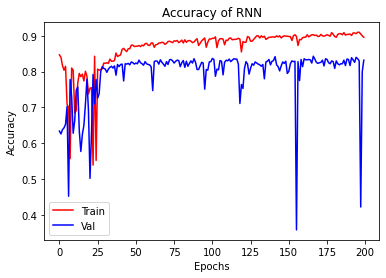

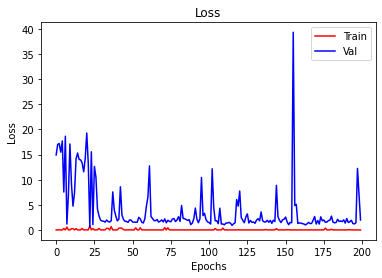

In [20]:
plt.plot(Results_acc.Epoch,Results_acc.Acc_train,'r',Results_acc.Epoch,Results_acc.Acc_val,'b')
plt.legend(['Train','Val'])
plt.title('Accuracy of RNN')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

plt.plot(Results_loss.Epoch,Results_loss.Loss_train,'r',Results_loss.Epoch,Results_loss.Loss_val,'b')
plt.legend(['Train','Val'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()

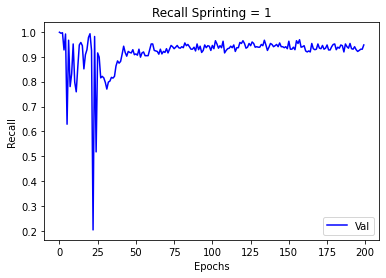

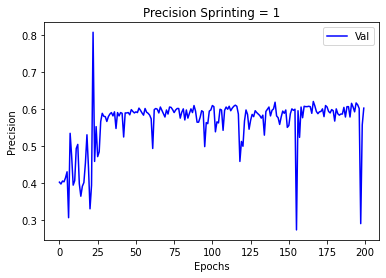

In [21]:
plt.plot(Results_recall.Epoch , Results_recall.Recall_val,'b')
plt.legend(['Val'])
plt.title('Recall Sprinting = 1')
plt.ylabel('Recall')
plt.xlabel('Epochs')
plt.show()

plt.plot(Results_prec.Epoch,Results_prec.Prec_val,'b')
plt.legend(['Val'])
plt.title('Precision Sprinting = 1')
plt.ylabel('Precision')
plt.xlabel('Epochs')
plt.show()

# Validate/Tune Model

Validate results of the model (Precision/Recall). Tune the parameters of the model to achieve better results

In [22]:
classes = ['Not Sprinting', 'Sprinting']
y_pred = CNN(X_val)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_val = y_val.cpu()
print(classification_report(y_val, y_pred, target_names=classes))

               precision    recall  f1-score   support

Not Sprinting       0.98      0.79      0.87      1624
    Sprinting       0.59      0.94      0.73       531

     accuracy                           0.83      2155
    macro avg       0.78      0.86      0.80      2155
 weighted avg       0.88      0.83      0.84      2155



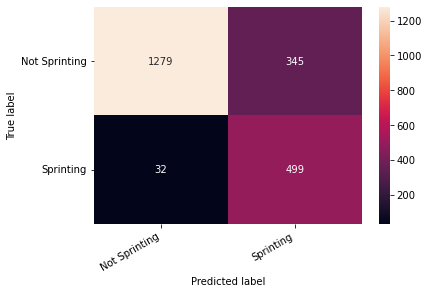

In [23]:
cm = confusion_matrix(y_val, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

# Closing Notebook

In [ ]:
%%javascript
Jupyter.notebook.session.delete();

<IPython.core.display.Javascript object>